# FAS score comparison fA genes against RefSeq annotated ones

1) export consensus set
2) get sequences and export them
3) start FAS
4) read in FAS
5) plot

In [1]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
import colorcet as cc

In [2]:
tools_ref = ['bbh', 'domainoid', 'ensemble', 'hieranoid', 'inparanoid', 'metaphors', 'oma_pairs', 'orthoffgc', 'orthofinder', 'orthoinspector', 'panther', 'rsd', 'sonicparanoid']
#tools = ['fdog_assembly_metazoa_augustus_gallus_v2', 'fdog_assembly_metazoa_metaeuk_gallus_v2_sens', 'compleasm_metazoa_gallus_v2']
tools = ['fdog_assembly_metazoa_augustus_gallus_v2', 'fdog_assembly_metazoa_metaeuk_gallus_v2_sens', 'busco_metazoa_augustus_species_gallus_v2', 'busco_metazoa_metaeuk_gallus_v2', 'compleasm_metazoa_gallus_v2', ]#fdog_assembly_metazoa_metaeuk_gallus_v2',
path = '../../results/qfo_input/'

In [3]:
def create_set_of_sets(path):
    file = open(path, 'r')
    pairs_set = set()
    lines = file.readlines()
    for line in lines:
        line = line.rstrip()
        pairs = frozenset(line.split('\t'))
        pairs_set.add(pairs)
    #print(len(lines))
    print(len(pairs_set))
    return pairs_set

In [4]:
list_of_sets_ref = []
dict_of_sets = {}
nr_orthologs_ref = []
for i in tools_ref:
    pairs_set = create_set_of_sets(path + i + '.tsv')
    list_of_sets_ref.append(pairs_set)
    dict_of_sets[i] = pairs_set
    nr_orthologs_ref.append(len(pairs_set))

8738
8945
8168
8422
8487
8979
7973
8616
9372
9006
8906
8606
9126


In [5]:
intersection_ref = set.intersection(*list_of_sets_ref)
print(len(list_of_sets_ref))
print(len(intersection_ref))
genes = set()
for pair in intersection_ref:
    genes = genes.union(pair)


13
5669


In [6]:
list_of_sets = []
for t in tools:
    print(t)
    pairs_set = create_set_of_sets(path + t + '.tsv')
    list_of_sets.append(pairs_set)
    dict_of_sets[t] = pairs_set
intersection_tools = set.intersection(*list_of_sets)
print(len(list_of_sets))
print(len(intersection_tools))

fdog_assembly_metazoa_augustus_gallus_v2
8232
fdog_assembly_metazoa_metaeuk_gallus_v2_sens
8384
busco_metazoa_augustus_species_gallus_v2
8597
busco_metazoa_metaeuk_gallus_v2
8621
compleasm_metazoa_gallus_v2
8712
5
7078


In [7]:
intersection_all = set.intersection(intersection_ref, intersection_tools)
print(len(intersection_all))

4915


In [8]:
#reference FAS scores
species_file = '../../data/fDOG-assembly/species_set_benchmark_v2.tsv'
species_folder = '../../data/qfo_eukaryota_2022/qfo_data_2022/Eukaryota/'
out_seq_file = '../seq_fas_tmp/seq_for_fas.fa'
out = open(out_seq_file, 'w')

species_dict = {}
species_dict['9606'] = {'name': 'Homo sapiens', 'uniprot': 'UP000005640', 'file': 'UP000005640_9606.fasta'}
genes_vs_sp = {}

file = open(species_file)
lines = file.readlines()
for line in lines:
    line = line.rstrip()
    if line.startswith('NCBI'):
        continue
    ncbi, name, uniprot, source, accession = line.split('\t')
    species_dict[ncbi] = {'name': name, 'uniprot': uniprot, 'file': uniprot + '_'  + ncbi + '.fasta'}

#print(species_dict)
for sp in species_dict:
    proteom = open(species_folder + species_dict[sp]['file'])
    lines = proteom.readlines()
    start = False
    for line in lines:
        line = line.rstrip()
        if line.startswith('>'):
            if start == True:
                out.write('\n')
            ID = line.split('|')[1]
            if ID in genes:
                genes_vs_sp[ID] = sp
                out.write('>' + ID + '\n')
                start = True
            else:
                start = False
                seq = None
        else:
            if start == True:
                out.write(line)
out.close()

In [9]:
pairs_out = open('../seq_fas_tmp/pairs.tsv', 'w')
for pair in intersection_all:
    g1, g2 = pair
    if genes_vs_sp[g1] == '9606':
        #print(genes_vs_sp[g1])
        seed = g1
        ortho = g2
    else:
        seed = g2
        ortho = g1
    
    pairs_out.write(seed + '\t' + ortho + '\n')
pairs_out.close()

In [10]:
#read in assembly results

phylo_augustus = '../augustus_busco_core/fdog_assembly_core_busco_metazoa_jul24_augustus.phyloprofile'
phylo_metaeuk = '../metaeuk_busco_core_sens/fdog_assembly_core_busco_metazoa_sens_jan25_metaeuk.phyloprofile'

augustus = pd.read_csv(phylo_augustus, sep='\t', header = 0)
metaeuk = pd.read_csv(phylo_metaeuk, sep='\t', header = 0)
augustus = augustus.drop(columns=['ncbiID'])
metaeuk = metaeuk.drop(columns=['ncbiID'])

augustus['orthoID'] = augustus['orthoID'].str.split('|').apply(lambda x: x[0] + '_' + x[2]).str.replace('.', '_')
metaeuk['orthoID'] = metaeuk['orthoID'].str.split('|').apply(lambda x: x[0] + '_' + x[2]).str.replace('.', '_')

/tmp/ipykernel_2303486/2903301092.py:11: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  augustus['orthoID'] = augustus['orthoID'].str.split('|').apply(lambda x: x[0] + '_' + x[2]).str.replace('.', '_')
/tmp/ipykernel_2303486/2903301092.py:12: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  metaeuk['orthoID'] = metaeuk['orthoID'].str.split('|').apply(lambda x: x[0] + '_' + x[2]).str.replace('.', '_')


In [11]:
display(augustus)

,geneID,orthoID,FAS_F,FAS_B
0,107574at33208,107574at33208_KB095811_1_1_g11_t1,0.3164,0.2794
1,107574at33208,107574at33208_CM000282_3_1_g1_t1,0.2958,0.8876
2,107574at33208,107574at33208_DS900495_1_1_g4_t1,0.3327,0.5793
3,107574at33208,107574at33208_9606_0:004d68,1.0000,1.0000
4,107574at33208,107574at33208_AE014297_3_1_g8_t1,0.9757,0.6420
...,...,...,...,...
10104,99614at33208,99614at33208_CM000278_3_1_g7_t1,0.6953,0.6641
10105,99614at33208,99614at33208_CM000094_5_1_g2_t1,0.9064,0.9953
10106,99614at33208,99614at33208_CM026980_1_1_g3_t1,0.9986,0.9986
10107,99614at33208,99614at33208_NC_030682_2_1_g3_t1,0.8083,1.0000


In [12]:
def create_transcript_uniprot_dict(file):
    lines = file.readlines()
    uni_dict = {}
    for line in lines:
        line = line.rstrip()
        try:
            seed, transcript, uniprot_id = line.split('\t')
            transcript = transcript.replace('.', '_')
            transcript = transcript.replace('_mRNA', '')
            uni_dict[transcript] = uniprot_id
        except ValueError:
            uni_dict[transcript] = None
    return uni_dict

In [13]:
#create dict seed uniprot
mapping_file_seeds = open('../uniprotid_to_group_assignment/mapping_busco_id_uniport_id.tsv', 'r')
seed_uniprot = {}
lines = mapping_file_seeds.readlines()
for line in lines:
    line = line.rstrip()
    busco, uniprot = line.split('\t')
    seed_uniprot[busco] = uniprot

In [14]:
# create dict to map transcript id against uniprot id if possible
mapping_file_augustus = open('../qfo_input/fdog_assembly_metazoa_augustus_gallus_v2_mapping_transcript_uniprot.tsv', 'r')
mapping_file_metaeuk = open('../qfo_input/fdog_assembly_metazoa_metaeuk_gallus_v2_mapping_transcript_uniprot_sens.tsv', 'r')

mapping_augustus = create_transcript_uniprot_dict(mapping_file_augustus)
mapping_metaeuk = create_transcript_uniprot_dict(mapping_file_metaeuk)

In [15]:
augustus['orthoID'] = augustus['orthoID'].map(mapping_augustus)
augustus['geneID'] = augustus['geneID'].map(seed_uniprot)
display(augustus)

,geneID,orthoID,FAS_F,FAS_B
0,P48553,T1FPI6,0.3164,0.2794
1,P48553,D6WU19,0.2958,0.8876
2,P48553,NaN,0.3327,0.5793
3,P48553,NaN,1.0000,1.0000
4,P48553,Q9VFB7,0.9757,0.6420
...,...,...,...,...
10104,Q12768,D6WDB2,0.6953,0.6641
10105,Q12768,A0A1D5PIR3,0.9064,0.9953
10106,Q12768,A0A8I6AFP0,0.9986,0.9986
10107,Q12768,Q6DIP9,0.8083,1.0000


In [16]:
# Set with allowed combinations/ frozen sets
allowed_combinations = intersection_all

# Funktion zum Überprüfen, ob eine Zeile in den erlaubten Kombinationen enthalten ist
def is_allowed(row):
    return frozenset([row['geneID'], row['orthoID']]) in allowed_combinations

# DataFrame filtern
filtered_augustus = augustus[augustus.apply(is_allowed, axis=1)]
filtered_augustus['tool'] = 'fDOG-Assembly Augustus'
display(filtered_augustus)

/tmp/ipykernel_2303486/174879205.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_augustus['tool'] = 'fDOG-Assembly Augustus'


,geneID,orthoID,FAS_F,FAS_B,tool
6,P48553,A0A1B8XXC7,0.9823,0.7736,fDOG-Assembly Augustus
7,P48553,A0A8M1RHJ2,0.6637,0.6663,fDOG-Assembly Augustus
8,P48553,F1MAQ4,0.9383,0.3816,fDOG-Assembly Augustus
9,Q9P2H3,Q28I56,0.7943,0.9974,fDOG-Assembly Augustus
10,Q9P2H3,A7S6M0,0.5959,0.9858,fDOG-Assembly Augustus
...,...,...,...,...,...
10095,Q8IWA0,A0A1D5P786,0.9589,0.9989,fDOG-Assembly Augustus
10100,Q12768,Q7ZVM1,0.6952,0.9987,fDOG-Assembly Augustus
10104,Q12768,D6WDB2,0.6953,0.6641,fDOG-Assembly Augustus
10105,Q12768,A0A1D5PIR3,0.9064,0.9953,fDOG-Assembly Augustus


In [17]:
display(metaeuk)
metaeuk['orthoID'] = metaeuk['orthoID'].map(mapping_metaeuk)
metaeuk['geneID'] = metaeuk['geneID'].map(seed_uniprot)
display(metaeuk)

,geneID,orthoID,FAS_F,FAS_B
0,102804at33208,102804at33208_DS717658_1_1_1,0.5681,0.9945
1,102804at33208,102804at33208_DS469823_1_1_1,0.6778,0.9973
2,102804at33208,102804at33208_NC_030677_2_1_1,0.9292,0.9457
3,102804at33208,102804at33208_AE014296_5_1_3,0.8861,0.9771
4,102804at33208,102804at33208_KB097572_1_1_1,0.7608,0.9930
...,...,...,...,...
10635,99987at33208,99987at33208_NC_007120_7_1_1,0.8996,0.8254
10636,99987at33208,99987at33208_AE014297_3_1_1,0.8590,0.9966
10637,99987at33208,99987at33208_KB097143_1_1_2,0.7848,0.8149
10638,99987at33208,99987at33208_CM026975_1_1_1,0.9603,0.8301


,geneID,orthoID,FAS_F,FAS_B
0,Q9Y5B9,B7PI85,0.5681,0.9945
1,Q9Y5B9,A7SV15,0.6778,0.9973
2,Q9Y5B9,F7EL37,0.9292,0.9457
3,Q9Y5B9,Q8IRG6,0.8861,0.9771
4,Q9Y5B9,T1FVE6,0.7608,0.9930
...,...,...,...,...
10635,Q9UNX4,Q6PFM8,0.8996,0.8254
10636,Q9UNX4,Q9VE98,0.8590,0.9966
10637,Q9UNX4,T1FYR8,0.7848,0.8149
10638,Q9UNX4,D4A106,0.9603,0.8301


In [18]:
# DataFrame filtern
filtered_metaeuk = metaeuk[metaeuk.apply(is_allowed, axis=1)]
filtered_metaeuk['tool'] = 'fDOG-Assembly MetaEuk'
display(filtered_metaeuk)

/tmp/ipykernel_2303486/1567990278.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_metaeuk['tool'] = 'fDOG-Assembly MetaEuk'


,geneID,orthoID,FAS_F,FAS_B,tool
1,Q9Y5B9,A7SV15,0.6778,0.9973,fDOG-Assembly MetaEuk
2,Q9Y5B9,F7EL37,0.9292,0.9457,fDOG-Assembly MetaEuk
3,Q9Y5B9,Q8IRG6,0.8861,0.9771,fDOG-Assembly MetaEuk
4,Q9Y5B9,T1FVE6,0.7608,0.9930,fDOG-Assembly MetaEuk
6,Q9Y5B9,Q9N5R9,0.7586,0.9807,fDOG-Assembly MetaEuk
...,...,...,...,...,...
10635,Q9UNX4,Q6PFM8,0.8996,0.8254,fDOG-Assembly MetaEuk
10636,Q9UNX4,Q9VE98,0.8590,0.9966,fDOG-Assembly MetaEuk
10637,Q9UNX4,T1FYR8,0.7848,0.8149,fDOG-Assembly MetaEuk
10638,Q9UNX4,D4A106,0.9603,0.8301,fDOG-Assembly MetaEuk


In [19]:
#compleasm 
#1) find uniref reference gene to every ortholog and build pairs -> compleasm_metazoa_gallus_v2_mapping_transcript_uniprot.tsv cut -f 1,2
#2) compute fas scores
#3) concat fas output
#4) read in fas output, replace transcript ids
#5) filter
#mapping file
mapping_file_compleasm = open('../qfo_input/compleasm_metazoa_gallus_v2_mapping_transcript_uniprot.tsv', 'r')
mapping_compleasm = create_transcript_uniprot_dict(mapping_file_compleasm)
#display(mapping_compleasm)
# read in fas output
fas_out = '../compleasm/fas_scores/fas_compleasm_vs_seed.tsv'
fas_compl = pd.read_csv(fas_out, sep='\t', header = 0)
#display(fas_compl)
fas_compl = fas_compl.drop(columns=['MS(Forward/Reverse)'])
fas_compl = fas_compl.drop(columns=['PS(Forward/Reverse)'])
fas_compl = fas_compl.drop(columns=['CS(Forward/Reverse)'])
fas_compl = fas_compl.drop(columns=['LS(Forward/Reverse)'])
fas_compl = fas_compl.drop(columns=['Method'])
fas_compl['tool'] = 'compleasm'
fas_compl[['FAS_F', 'FAS_B']] = fas_compl['Score(Forward/Reverse)'].str.split('/', expand=True)
fas_compl = fas_compl.drop(columns=['Score(Forward/Reverse)'])
fas_compl = fas_compl.rename(columns={"Seed": "geneID", "Query": "orthoID"})
display(fas_compl)
fas_compl["orthoID"] = fas_compl["orthoID"].str.replace(".", "_", regex=False)
fas_compl['orthoID'] = fas_compl['orthoID'].map(mapping_compleasm)
display(fas_compl)
filtered_fas_compl = fas_compl[fas_compl.apply(is_allowed, axis=1)]
display(filtered_fas_compl)
filtered_fas_compl["FAS_F"] = pd.to_numeric(filtered_fas_compl["FAS_F"])
filtered_fas_compl["FAS_B"] = pd.to_numeric(filtered_fas_compl["FAS_B"])


,geneID,orthoID,tool,FAS_F,FAS_B
0,A0AVI4,289235at33208_10228_0:000940|NC_007125.7:95819...,compleasm,0.9982,0.6655
1,A0AVI4,289235at33208_166361_0:00340e|CM000096.5:83906...,compleasm,0.8751,0.6653
2,A0AVI4,289235at33208_166361_0:00340e|CM000284.3:67659...,compleasm,0.9971,0.9971
3,A0AVI4,289235at33208_218467_0:000dfa|CM026987.1:77065...,compleasm,0.9977,0.4988
4,A0AVI4,289235at33208_35019_0:00066c|NC_030677.2:20362...,compleasm,0.9976,0.9976
...,...,...,...,...,...
8443,Q9Y6N1,526074at33208_199890_0:001b9b|KB095812.1:47507...,compleasm,0.9426,0.9426
8444,Q9Y6N1,526074at33208_211228_0:000b61|NC_007123.7:3206...,compleasm,0.9329,0.9329
8445,Q9Y6N1,526074at33208_211228_0:000b61|NW_018394853.1:3...,compleasm,0.9329,0.9329
8446,Q9Y6N1,526074at33208_45351_0:002d0c|NC_030682.2:14720...,compleasm,0.932,0.6214


,geneID,orthoID,tool,FAS_F,FAS_B
0,A0AVI4,NaN,compleasm,0.9982,0.6655
1,A0AVI4,F1NCL6,compleasm,0.8751,0.6653
2,A0AVI4,A0A139WCB1,compleasm,0.9971,0.9971
3,A0AVI4,B1WBR6,compleasm,0.9977,0.4988
4,A0AVI4,Q0IJ33,compleasm,0.9976,0.9976
...,...,...,...,...,...
8443,Q9Y6N1,T1G0K6,compleasm,0.9426,0.9426
8444,Q9Y6N1,A3KNN8,compleasm,0.9329,0.9329
8445,Q9Y6N1,A3KNN8,compleasm,0.9329,0.9329
8446,Q9Y6N1,A0A8J0QJU6,compleasm,0.932,0.6214


,geneID,orthoID,tool,FAS_F,FAS_B
2,A0AVI4,A0A139WCB1,compleasm,0.9971,0.9971
4,A0AVI4,Q0IJ33,compleasm,0.9976,0.9976
6,A0AVI4,T1EE57,compleasm,0.866,0.658
7,A0AVI4,Q9VN16,compleasm,0.7456,0.6651
10,A0JLT2,Q07FY3,compleasm,0.8438,0.9893
...,...,...,...,...,...
8440,Q9Y6N1,D6WEX2,compleasm,0.932,0.932
8441,Q9Y6N1,D3ZNJ0,compleasm,0.932,0.932
8444,Q9Y6N1,A3KNN8,compleasm,0.9329,0.9329
8445,Q9Y6N1,A3KNN8,compleasm,0.9329,0.9329


/tmp/ipykernel_2303486/1701666089.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_fas_compl["FAS_F"] = pd.to_numeric(filtered_fas_compl["FAS_F"])
/tmp/ipykernel_2303486/1701666089.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_fas_compl["FAS_B"] = pd.to_numeric(filtered_fas_compl["FAS_B"])


In [20]:
counter = 0
for key in mapping_compleasm:
    print(key)
    counter += 1
    if counter == 4:
        break

102804at33208_10224_0:00116b|BX284601_5:10789136-10792883
130245at33208_123851_0:000233|BX284601_5:6422185-6424019
13816at33208_10224_0:00365f|BX284601_5:8828420-8838349
153034at33208_10228_0:0013db|BX284601_5:13566448-13571970


In [32]:
#busco Augustus with species parameter
mapping_file_busco_aug = open('../qfo_input/busco_metazoa_augustus_species_gallus_v2_mapping_transcript_uniprot.tsv', 'r')
mapping_busco_aug = create_transcript_uniprot_dict(mapping_file_busco_aug)
#display(mapping_busco_aug)
#write filtered pairs
pairs = pd.read_csv('../qfo_input/busco_metazoa_augustus_species_gallus_v2_mapping_transcript_uniprot.tsv', sep='\t', header=None, names=["geneID", "transcript", "orthoID"])
display(pairs)
filtered_pairs = pairs[pairs.apply(is_allowed, axis=1)]
display(filtered_pairs)
filtered_pairs["IDs"] = filtered_pairs["transcript"]
filtered_pairs["IDs"] = filtered_pairs["IDs"].str.split('_r').str[0]
filtered_pairs["IDs"] = filtered_pairs["IDs"].str.split('_g').str[0]
#filtered_pairs["transcript"] = filtered_pairs["transcript"].str.split('_').str[1]
display(filtered_pairs)
#dups = filtered_pairs[filtered_pairs.duplicated(subset=["transcript", "orthoID"], keep=False)]
#display(dups)
filtered_pairs.to_csv('../busco/augustus_with_species_parameter/fas_results/pairs_full_list.tsv', sep='\t', index=False, header=False)

,geneID,transcript,orthoID
0,Q9Y5B9,BX284601.5:10789087-10797610_r2.m1.g3.t1,Q9N5R9
1,Q09161,BX284601.5:6420887-6425669_r2.m1.g1.t1,O01763
2,O95071,BX284601.5:8824397-8841505_r2.m1.g2.t1,Q65ZA8
3,Q96BP3,BX284601.5:13566396-13571914_r2.m1.g2.t1,Q9U1Q3
4,Q8IYI6,BX284601.5:14631498-14642621_r2.m1.g1.t1,Q95Q35
...,...,...,...
9608,Q9BTX3,NC_030680.2:76435785-76443053_r2.m1.g2.t1,B0JZX4
9609,P61218,NC_030680.2:122154221-122158435_r2.m1.g3.t1,Q6DDA6
9610,Q16531,NC_030680.2:24036157-24057494_r2.m1.g1.t1,A0A6I8QS73
9611,Q9ULW3,NW_022279393.1:1-2509_r2.m1.g1.t1,A0A8J0QFS4


,geneID,transcript,orthoID
0,Q9Y5B9,BX284601.5:10789087-10797610_r2.m1.g3.t1,Q9N5R9
1,Q09161,BX284601.5:6420887-6425669_r2.m1.g1.t1,O01763
4,Q8IYI6,BX284601.5:14631498-14642621_r2.m1.g1.t1,Q95Q35
5,Q8IYI6,BX284601.5:14631498-14642621_r2.m1.g1.t1,Q95Q35
6,Q07864,BX284601.5:15005606-15013911_r2.m1.g2.t1,O62218
...,...,...,...
9604,Q13405,NC_030680.2:31552472-31556776_r2.m1.g2.t1,A0A6I8PR91
9605,P62310,NC_030680.2:132914992-132921146_r2.m1.g1.t1,A9JSD0
9606,O14737,NC_030680.2:69434224-69441987_r2.m1.g2.t1,A0A6I8Q473
9609,P61218,NC_030680.2:122154221-122158435_r2.m1.g3.t1,Q6DDA6


/tmp/ipykernel_2303486/1181127987.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_pairs["IDs"] = filtered_pairs["transcript"]
/tmp/ipykernel_2303486/1181127987.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_pairs["IDs"] = filtered_pairs["IDs"].str.split('_r').str[0]
/tmp/ipykernel_2303486/1181127987.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

,geneID,transcript,orthoID,IDs
0,Q9Y5B9,BX284601.5:10789087-10797610_r2.m1.g3.t1,Q9N5R9,BX284601.5:10789087-10797610
1,Q09161,BX284601.5:6420887-6425669_r2.m1.g1.t1,O01763,BX284601.5:6420887-6425669
4,Q8IYI6,BX284601.5:14631498-14642621_r2.m1.g1.t1,Q95Q35,BX284601.5:14631498-14642621
5,Q8IYI6,BX284601.5:14631498-14642621_r2.m1.g1.t1,Q95Q35,BX284601.5:14631498-14642621
6,Q07864,BX284601.5:15005606-15013911_r2.m1.g2.t1,O62218,BX284601.5:15005606-15013911
...,...,...,...,...
9604,Q13405,NC_030680.2:31552472-31556776_r2.m1.g2.t1,A0A6I8PR91,NC_030680.2:31552472-31556776
9605,P62310,NC_030680.2:132914992-132921146_r2.m1.g1.t1,A9JSD0,NC_030680.2:132914992-132921146
9606,O14737,NC_030680.2:69434224-69441987_r2.m1.g2.t1,A0A6I8Q473,NC_030680.2:69434224-69441987
9609,P61218,NC_030680.2:122154221-122158435_r2.m1.g3.t1,Q6DDA6,NC_030680.2:122154221-122158435


In [33]:
#busco MetaEuk
mapping_file_busco_meta = open('../qfo_input/busco_metazoa_metaeuk_gallus_v2_mapping_transcript_uniprot.tsv', 'r')
mapping_busco_meta = create_transcript_uniprot_dict(mapping_file_busco_meta)
#display(mapping_busco_aug)
#write filtered pairs
pairs = pd.read_csv('../qfo_input/busco_metazoa_metaeuk_gallus_v2_mapping_transcript_uniprot.tsv', sep='\t', header=None, names=["geneID", "transcript", "orthoID"])
display(pairs)
filtered_pairs = pairs[pairs.apply(is_allowed, axis=1)]
display(filtered_pairs)
filtered_pairs["IDs"] = filtered_pairs["transcript"]
filtered_pairs["IDs"] = filtered_pairs["IDs"].str.split('_r').str[0]
filtered_pairs["IDs"] = filtered_pairs["IDs"].str.split('_g').str[0]
#filtered_pairs["transcript"] = filtered_pairs["transcript"].str.split('_').str[1]
display(filtered_pairs)
#dups = filtered_pairs[filtered_pairs.duplicated(subset=["transcript", "orthoID"], keep=False)]
#display(dups)
filtered_pairs.to_csv('../busco/metaeuk/fas_results/pairs_full_list.tsv', sep='\t', index=False, header=False)

,geneID,transcript,orthoID
0,O60725,446000at33208_6239_0:00007b|BX284601.5|+|55821...,P91402
1,O60725,446000at33208_6239_0:000685|BX284601.5|+|49019...,P91266
2,Q7JRC0,642773at33208_6239_0:000102|BX284601.5|+|74923...,Q22850
3,Q96DI7,357580at33208_6239_0:00073f|BX284601.5|+|41932...,O02097
4,P62750,603370at33208_6239_0:000148|BX284601.5|-|83291...,Q20647
...,...,...,...
9022,Q9H0W8,580896at33208_8364_0:002ee5|NC_030683.2|+|1199...,B5DDX6
9023,Q92538,49474at33208_8364_0:003424|NC_030683.2|+|43906...,A0A8J1JY23
9024,O95260,273040at33208_8364_0:002f7a|NC_030683.2|+|1916...,A0A6I8RNN9
9025,P17152,504691at33208_8364_0:002fbb|NC_030683.2|+|1040...,A0A8J0QPL2


,geneID,transcript,orthoID
7,O95260,273040at33208_6239_0:0009e0|BX284601.5|-|96119...,P90914
8,O95260,273040at33208_6239_0:0009e0|BX284601.5|-|96119...,P90914
9,O95260,273040at33208_6239_0:0009e0|BX284601.5|-|96119...,P90914
16,Q9Y3C1,579029at33208_6239_0:00094b|BX284601.5|+|82553...,Q94402
19,Q96BW9,395556at33208_6239_0:000583|BX284601.5|+|27315...,Q9N4G7
...,...,...,...
9020,P46776,578354at33208_8364_0:0032e2|NC_030683.2|+|7762...,A0A8J1JS44
9021,Q9Y3B2,539600at33208_8355_0:004d6f|NC_030683.2|+|3298...,F6SHA1
9022,Q9H0W8,580896at33208_8364_0:002ee5|NC_030683.2|+|1199...,B5DDX6
9023,Q92538,49474at33208_8364_0:003424|NC_030683.2|+|43906...,A0A8J1JY23


/tmp/ipykernel_2303486/2035483383.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_pairs["IDs"] = filtered_pairs["transcript"]
/tmp/ipykernel_2303486/2035483383.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_pairs["IDs"] = filtered_pairs["IDs"].str.split('_r').str[0]
/tmp/ipykernel_2303486/2035483383.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

,geneID,transcript,orthoID,IDs
7,O95260,273040at33208_6239_0:0009e0|BX284601.5|-|96119...,P90914,273040at33208_6239_0:0009e0|BX284601.5|-|96119...
8,O95260,273040at33208_6239_0:0009e0|BX284601.5|-|96119...,P90914,273040at33208_6239_0:0009e0|BX284601.5|-|96119...
9,O95260,273040at33208_6239_0:0009e0|BX284601.5|-|96119...,P90914,273040at33208_6239_0:0009e0|BX284601.5|-|96119...
16,Q9Y3C1,579029at33208_6239_0:00094b|BX284601.5|+|82553...,Q94402,579029at33208_6239_0:00094b|BX284601.5|+|82553...
19,Q96BW9,395556at33208_6239_0:000583|BX284601.5|+|27315...,Q9N4G7,395556at33208_6239_0:000583|BX284601.5|+|27315...
...,...,...,...,...
9020,P46776,578354at33208_8364_0:0032e2|NC_030683.2|+|7762...,A0A8J1JS44,578354at33208_8364_0:0032e2|NC_030683.2|+|7762...
9021,Q9Y3B2,539600at33208_8355_0:004d6f|NC_030683.2|+|3298...,F6SHA1,539600at33208_8355_0:004d6f|NC_030683.2|+|3298...
9022,Q9H0W8,580896at33208_8364_0:002ee5|NC_030683.2|+|1199...,B5DDX6,580896at33208_8364_0:002ee5|NC_030683.2|+|1199...
9023,Q92538,49474at33208_8364_0:003424|NC_030683.2|+|43906...,A0A8J1JY23,49474at33208_8364_0:003424|NC_030683.2|+|43906...


In [21]:
#read in reference fas scores and produce dataframe
fas_out = '../seq_fas_tmp/fas_consensus_set_vs_seed.tsv'
fas_ref = pd.read_csv(fas_out, sep='\t', header = 0)
fas_ref = fas_ref.drop(columns=['MS(Forward/Reverse)'])
fas_ref = fas_ref.drop(columns=['PS(Forward/Reverse)'])
fas_ref = fas_ref.drop(columns=['CS(Forward/Reverse)'])
fas_ref = fas_ref.drop(columns=['LS(Forward/Reverse)'])
fas_ref = fas_ref.drop(columns=['Method'])
fas_ref['tool'] = 'Reference'
fas_ref[['FAS_F', 'FAS_B']] = fas_ref['Score(Forward/Reverse)'].str.split('/', expand=True)
fas_ref = fas_ref.drop(columns=['Score(Forward/Reverse)'])
fas_ref = fas_ref.rename(columns={"Seed": "geneID", "Query": "orthoID"})
#display(fas_ref)
filtered_fas_ref = fas_ref[fas_ref.apply(is_allowed, axis=1)]
#display(fas_ref)
filtered_fas_ref["FAS_F"] = pd.to_numeric(filtered_fas_ref["FAS_F"])
filtered_fas_ref["FAS_B"] = pd.to_numeric(filtered_fas_ref["FAS_B"])

/tmp/ipykernel_2284135/2816398036.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_fas_ref["FAS_F"] = pd.to_numeric(filtered_fas_ref["FAS_F"])
/tmp/ipykernel_2284135/2816398036.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_fas_ref["FAS_B"] = pd.to_numeric(filtered_fas_ref["FAS_B"])


In [22]:
combined_df = pd.concat([filtered_fas_ref, filtered_augustus, filtered_metaeuk, filtered_fas_compl], ignore_index=True)
display(combined_df)

,geneID,orthoID,tool,FAS_F,FAS_B
0,Q8NFJ9,Q9VS19,Reference,0.5523,0.9560
1,Q9VH78,Q23361,Reference,0.8487,0.7080
2,Q9BY42,Q3T1J8,Reference,0.9992,0.6662
3,Q0VDI3,A0A8I6AG39,Reference,0.9920,0.1935
4,Q9NVU7,A4IIB1,Reference,0.9957,0.9746
...,...,...,...,...,...
20139,Q9Y6N1,D6WEX2,compleasm,0.9320,0.9320
20140,Q9Y6N1,D3ZNJ0,compleasm,0.9320,0.9320
20141,Q9Y6N1,A3KNN8,compleasm,0.9329,0.9329
20142,Q9Y6N1,A3KNN8,compleasm,0.9329,0.9329


In [23]:
palette = sb.hls_palette(17)
print(palette)
print(palette.as_hex())
color_dict = {
    'BUSCO_augustus': '#d60000',
    'BUSCO_augustus_species': '#d60000',
    'BUSCO_metaeuk': '#8c3bff', 
    'bbh': '#97ff00', 
    'domainoid': '#00acc6', 
    'ensembl': '#6b004f', 
    'fDOG-Assembly_augustus': '#ff7ed1',
    'fdog_assembly_human_proteom_augustus': '#ff7ed1',
    'fdog_assembly_human_proteom_metaeuk': '#018700',
    'fDOG-Assembly_metaeuk': '#018700', 
    'hieranoid': '#ffa52f', 
    'inparanoid': '#573b00', 
    'metaphors': '#00fdcf', 
    'OMA_pairs': '#0000dd',
    'oma_pairs': '#0000dd',
    'orthoffgc': '#005659', 
    'orthofinder': '#a17569', 
    'orthoinspector': '#bcb6ff', 
    'panther': '#95b577', 
    'rsd': '#645474', 
    'sonicparanoid': '#bf03b8',
    'fDOG-Assembly Augustus': '#ff7ed1',
    'fDOG-Assembly MetaEuk': '#018700',
    'fdog_assembly_metazoa_metaeuk_sens': '#018700',
    'Reference': '#0000dd',
    'compleasm': '#CBBD93'
}

marker_dict = {
    'BUSCO_augustus': 'X',
    'BUSCO_augustus_species': 'X',
    'BUSCO_metaeuk': 'X', 
    'bbh': 's', 
    'domainoid': 'd', 
    'ensembl': 'p', 
    'ensamble': 'p',
    'fDOG-Assembly_augustus': 'X', 
    'fDOG-Assembly_metaeuk': 'X',
    'fdog_assembly_metazoa_metaeuk_sens':'X',
    'hieranoid': 'o', 
    'inparanoid': 'v', 
    'metaphors': 's', 
    'OMA_pairs': 'd',
    'oma_pairs': 'd',
    'orthoffgc': 'p', 
    'orthofinder': 'o', 
    'orthoinspector': 'v', 
    'panther': 's', 
    'rsd': 'd', 
    'sonicparanoid': 'p',
    'fDOG-Assembly Augustus': 'o',
    'fDOG-Assembly MetaEuk': 'v',
    'Reference': 'p',
    'compleasm': 'X'
}


[(0.86, 0.3712, 0.33999999999999997), (0.86, 0.5547294117647059, 0.33999999999999997), (0.86, 0.7382588235294117, 0.33999999999999997), (0.7982117647058823, 0.86, 0.33999999999999997), (0.6146823529411763, 0.86, 0.33999999999999997), (0.4311529411764704, 0.86, 0.33999999999999997), (0.33999999999999997, 0.86, 0.43237647058823525), (0.33999999999999997, 0.86, 0.6159058823529412), (0.33999999999999997, 0.86, 0.7994352941176471), (0.33999999999999997, 0.7370352941176468, 0.86), (0.33999999999999997, 0.553505882352941, 0.86), (0.33999999999999997, 0.369976470588235, 0.86), (0.49355294117647014, 0.33999999999999997, 0.86), (0.677082352941176, 0.33999999999999997, 0.86), (0.86, 0.33999999999999997, 0.8593882352941175), (0.86, 0.33999999999999997, 0.6758588235294114), (0.86, 0.33999999999999997, 0.4923294117647055)]
['#db5f57', '#db8d57', '#dbbc57', '#ccdb57', '#9ddb57', '#6edb57', '#57db6e', '#57db9d', '#57dbcc', '#57bcdb', '#578ddb', '#575edb', '#7e57db', '#ad57db', '#db57db', '#db57ac', '#

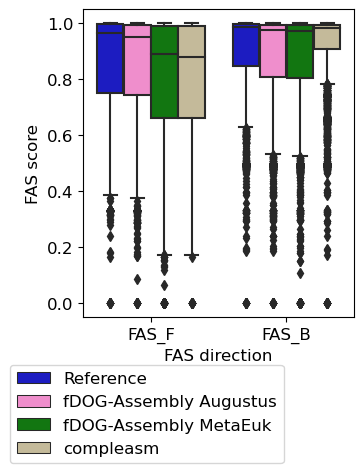

In [24]:

# Melt the dataframe
df_melted = combined_df.melt(id_vars='tool', value_vars=['FAS_F', 'FAS_B'], var_name='FAS direction', value_name='FAS score')
#display(df_melted)
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(3.5, 4))
# Create the boxplot
sb.boxplot(x='FAS direction', y='FAS score', hue='tool', data=df_melted, palette=color_dict)
# Place the legend outside the plot
plt.legend(bbox_to_anchor=(-0.3, -0.5),loc='lower left')
plt.savefig('fas_score_comparison_consensus_set.svg', format='svg')
plt.show()

In [25]:
display(df_melted)
print(df_melted[(df_melted['tool'] == 'Reference') & (df_melted['FAS direction'] == 'FAS_F')]['FAS score'].median())
print(df_melted[(df_melted['tool'] == 'Reference') & (df_melted['FAS direction'] == 'FAS_B')]['FAS score'].median())

,tool,FAS direction,FAS score
0,Reference,FAS_F,0.5523
1,Reference,FAS_F,0.8487
2,Reference,FAS_F,0.9992
3,Reference,FAS_F,0.9920
4,Reference,FAS_F,0.9957
...,...,...,...
40283,compleasm,FAS_B,0.9320
40284,compleasm,FAS_B,0.9320
40285,compleasm,FAS_B,0.9329
40286,compleasm,FAS_B,0.9329


0.9643
0.9854


In [26]:
print(df_melted[(df_melted['tool'] == 'fDOG-Assembly Augustus') & (df_melted['FAS direction'] == 'FAS_F')]['FAS score'].median())
print(df_melted[(df_melted['tool'] == 'fDOG-Assembly Augustus') & (df_melted['FAS direction'] == 'FAS_B')]['FAS score'].median())

0.9503
0.9773499999999999


In [27]:
print(df_melted[(df_melted['tool'] == 'fDOG-Assembly MetaEuk') & (df_melted['FAS direction'] == 'FAS_F')]['FAS score'].median())
print(df_melted[(df_melted['tool'] == 'fDOG-Assembly MetaEuk') & (df_melted['FAS direction'] == 'FAS_B')]['FAS score'].median())

0.8898
0.973
